In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn import svm, tree
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix


In [2]:
df  = pd.read_csv("modelling_data/ready_data.csv")
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,inq_last_6mths,pub_rec,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,fico_average,term,grade,target
0,5000.0,5000.0,4975.0,10.65,24000.0,27.65,1.0,0.0,83.7,9.0,5863.155187,5833.84,0.00,0.00,0.00,171.62,737.0,0.741507,2,1
1,2500.0,2500.0,2500.0,15.27,30000.0,1.00,5.0,0.0,9.4,4.0,1008.710000,1008.71,0.00,117.08,1.11,119.66,742.0,0.258493,3,0
2,2400.0,2400.0,2400.0,15.96,12252.0,8.72,2.0,0.0,98.5,10.0,3005.666844,3005.67,0.00,0.00,0.00,649.91,737.0,0.741507,3,1
3,10000.0,10000.0,10000.0,13.49,49200.0,20.00,1.0,0.0,21.0,37.0,12231.890000,12231.89,16.97,0.00,0.00,357.48,692.0,0.741507,3,1
4,5000.0,5000.0,5000.0,7.90,36000.0,11.20,3.0,0.0,28.3,12.0,5632.210000,5632.21,0.00,0.00,0.00,161.03,732.0,0.741507,1,1


In [3]:
df.shape

(39239, 20)

##### Check for imbalanced classes in the target feature

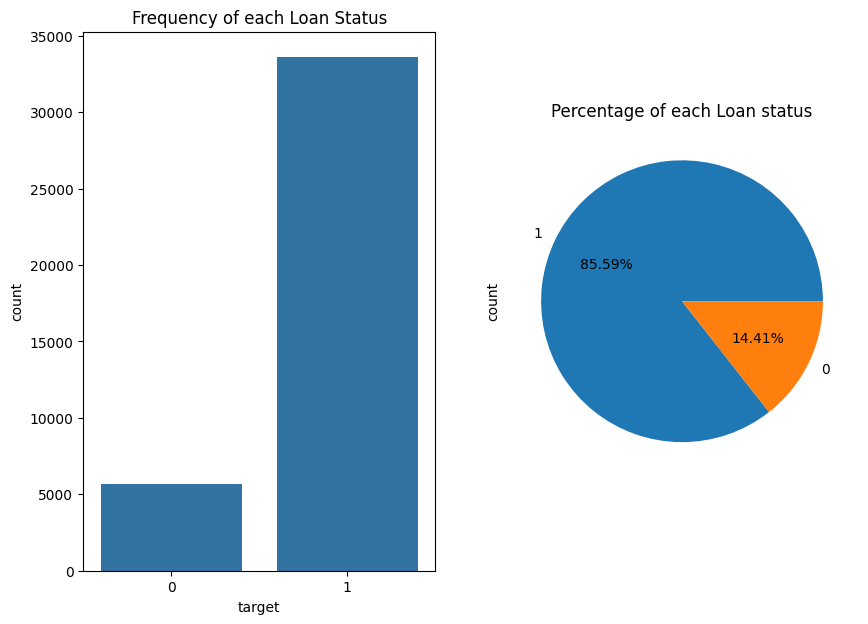

In [4]:
fig, axs = plt.subplots(1,2,figsize=(10,7))
sns.countplot(x='target',data=df,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
df.target.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

Since we have class imbalance we use a method provided by sklearn for calculating class weights so the model learns to predict the minority class properly. Note that not all models have an option for defining class weights so another approach for handling class imabalance would be necessary.

In [5]:
Y = df['target'].values
b = sklearn.utils.class_weight.compute_class_weight( class_weight = "balanced",
                                                    classes = np.unique(Y),
                                                    y = Y)
print(b)

[3.47063506 0.58415709]


In [6]:
class_weight = dict(zip([0,1], b))
class_weight

{0: 3.470635061029542, 1: 0.5841570892633835}

In [7]:
mean = df.mean()

#### Apply flooring and capping to deal with outliers 

In [8]:
for col in df.columns:
    percentiles = df[col].quantile([0.01,0.99]).values
    df[col] = np.clip(df[col], percentiles[0], percentiles[1])

In [9]:
mean2 = df.mean()
means = []
means = pd.DataFrame(means)
means['mean1'] = mean
means['mean2'] = pd.DataFrame(mean2)

In [10]:
diff = (abs(means.mean1.values - means.mean2.values)/means.mean1.values)*100

In [11]:
means['diff'] = diff #this is the difference in percentage 

In [12]:
print(means)

                                mean1         mean2       diff
loan_amnt                11134.730115  11136.456077   0.015501
funded_amnt              10863.217080  10864.952598   0.015976
funded_amnt_inv          10307.088303  10309.202434   0.020511
int_rate                    11.981232     11.971730   0.079314
annual_inc               68884.323399  67152.720212   2.513784
dti                         13.293984     13.281155   0.096505
inq_last_6mths               0.870359      0.859349   1.264933
pub_rec                      0.055404      0.053595   3.265869
revol_util                  48.675557     48.667846   0.015843
total_acc                   22.072428     22.027371   0.204133
total_pymnt              12040.915831  11994.576893   0.384846
total_pymnt_inv          11448.427009  11402.055200   0.405050
total_rec_late_fee           1.376608      1.142071  17.037265
recoveries                  97.395175     63.430243  34.873321
collection_recovery_fee     12.739819      5.491327  56

3 of the parameters have significant difference in the mean. We will build the 2 models using the dataset after applying flooring and capping and see the results 

#### Splitting the data for training and testing the models

In [13]:
X = df.drop('target', axis =1 )
Y = df.target
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,random_state=1)

The models will be KNN and RF

In [14]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

print('KNN Score for the training phase: ', knn.score(x_train,y_train))

print('K-Nearest Neighbors Score for the testing phase : ',knn.score(x_test,y_test))

KNN Score for the training phase:  0.9714886432416935
K-Nearest Neighbors Score for the testing phase :  0.9649592252803262


In [15]:
rf = RandomForestClassifier()

rf.fit(x_train,y_train)

print('Random Forest Score training phase : ',rf.score(x_train,y_train))

print('Random Forest Score for testing phase: ',rf.score(x_test,y_test))

Random Forest Score training phase :  1.0
Random Forest Score for testing phase:  0.9938837920489296


Those scores show that some of the features have a strong correlation with the target feature. After checking the correlation done in the previous part of the code we can see that:

1. 6 of the features have high correlation with the target and are: total_pymnt, total_pymnt_inv, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_amnt.
2. After checking the description of each of the features it turns out that all of them leak information from the future, which explains why our models were overfitting.
3. The 3 features with high difference in mean after dealing with outliers are among those 6 features

To solve this issue we will drop the feature from the dataset and move on to modeling.

In [16]:
droplist = ['total_pymnt','total_pymnt_inv','total_rec_late_fee','recoveries', 'collection_recovery_fee','last_pymnt_amnt']
df = df.drop(droplist,axis=1)

#### Building the models

In [17]:
X = df.drop('target', axis =1 )
Y = df.target
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,random_state=1)

##### 1. K-Nearest Neighbor

In [18]:
# we can check the parameters for the algorithm
KNeighborsClassifier()

KNeighborsClassifier()

In [19]:
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(x_train,y_train)

print('KNN Score for the training phase: ', knn.score(x_train,y_train))

print('K-Nearest Neighbors Score for the testing phase : ',knn.score(x_test,y_test))


KNN Score for the training phase:  0.8658851263100888
K-Nearest Neighbors Score for the testing phase :  0.8321865443425076


##### 2. Random Forest

In [20]:
RandomForestClassifier()

RandomForestClassifier()

In [21]:
rf = RandomForestClassifier(n_estimators = 20, class_weight ='balanced')

rf.fit(x_train,y_train)

print('Random Forest Score training phase : ',rf.score(x_train,y_train))

print('Random Forest Score for testing phase: ',rf.score(x_test,y_test))


Random Forest Score training phase :  0.9969417986046956
Random Forest Score for testing phase:  0.8470948012232415


##### 3. Support Vector Machine - SVM

In [22]:
svm.SVC()

SVC()

In [38]:
clf = svm.SVC(C=1000,class_weight=class_weight, gamma = 5)

clf.fit(x_train, y_train)

print('SVM Score training phase : ',clf.score(x_train,y_train))

print('SVM Score for testing phase: ',clf.score(x_test,y_test))

SVM Score training phase :  1.0
SVM Score for testing phase:  0.854230377166157


In [23]:
clf = svm.SVC(C=0.6,class_weight= 'balanced', gamma = 0.001)

clf.fit(x_train, y_train)

print('SVM Score training phase : ',clf.score(x_train,y_train))

print('SVM Score for testing phase: ',clf.score(x_test,y_test))

SVM Score training phase :  0.9786563027619382
SVM Score for testing phase:  0.8305300713557594


##### 4. Decision Trees

In [24]:
print(tree.DecisionTreeClassifier())
dt = tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = 30,  min_samples_split= 4)

DecisionTreeClassifier()


In [25]:
dt.fit(x_train, y_train)

print('Decision Trees training phase : ',dt.score(x_train,y_train))

print('Decision Trees Score for testing phase: ',dt.score(x_test,y_test))

Decision Trees training phase :  0.9788792966136791
Decision Trees Score for testing phase:  0.7559887869520897


##### 5. XGBoost

In [26]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [79]:
#model = XGBClassifier(max_depth = 9, scale_pos_weight = 4)
xgbmodel = XGBClassifier(max_depth = 8, learning_rate = 0.01, n_estimators = 1000)

xgbmodel.fit(x_train, y_train)

print('XGBoost Score training phase : ', xgbmodel.score(x_train,y_train))

print('XGBoost Score for testing phase: ', xgbmodel.score(x_test,y_test))

XGBoost Score training phase :  0.8888534930394062
XGBoost Score for testing phase:  0.85282874617737


##### 6. Neural Network

In [138]:
nn_model = Sequential()
nn_model.add(Dense(13,input_dim = 13, activation = 'relu'))
nn_model.add(Dense(4, activation = 'relu'))
nn_model.add(Dense(1, activation = 'sigmoid'))

In [139]:
nn_model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [140]:
nn_model.fit(x_train,y_train,epochs = 50, batch_size = 80, class_weight=class_weight)

Epoch 1/50
393/393 [==============================] - 2s 2ms/step - loss: 11.3680 - accuracy: 0.1752
Epoch 2/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6960 - accuracy: 0.2244
Epoch 3/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.6080
Epoch 4/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.3267
Epoch 5/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.7007
Epoch 6/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.7291
Epoch 7/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.7696
Epoch 8/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.7738
Epoch 9/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.5450
Epoch 10/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.362

#### Final accuracy score 

In [141]:
scores = nn_model.evaluate(x_test,y_test)
print('\n%s: %.2f%%'% (nn_model.metrics_names[1], scores[1]*100))

246/246 [==============================] - 1s 2ms/step - loss: 0.6926 - accuracy: 0.8542

accuracy: 85.42%


#### adding Dropout after the hidden layer

In [142]:
from keras.layers import Dropout
nn_model_dropout = Sequential()
nn_model_dropout.add(Dense(13,input_dim = 13, activation = 'relu'))
nn_model_dropout.add(Dense(3, activation = 'relu'))
nn_model_dropout.add(Dropout(0.5))
nn_model_dropout.add(Dense(1, activation = 'sigmoid'))

In [143]:
nn_model_dropout.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

In [144]:
nn_model_dropout.fit(x_train,y_train,epochs = 50, batch_size = 80, class_weight = class_weight)

Epoch 1/50
393/393 [==============================] - 2s 2ms/step - loss: 33.2833 - accuracy: 0.8347
Epoch 2/50
393/393 [==============================] - 1s 2ms/step - loss: 0.7745 - accuracy: 0.8563
Epoch 3/50
393/393 [==============================] - 1s 2ms/step - loss: 0.7442 - accuracy: 0.5788
Epoch 4/50
393/393 [==============================] - 1s 2ms/step - loss: 0.7314 - accuracy: 0.8130
Epoch 5/50
393/393 [==============================] - 1s 2ms/step - loss: 0.7003 - accuracy: 0.5401
Epoch 6/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.7694
Epoch 7/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.7903
Epoch 8/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6945 - accuracy: 0.2894
Epoch 9/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.5104
Epoch 10/50
393/393 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.472

Using accuracy scores is a nice way to check the models performance, however to better check how well the models did predicting the target feature confusion matrix is used.

### Building confusion matrices for each model

##### 1. Confusion Matrix for KNN predictions

Text(95.72222222222221, 0.5, 'Truth')

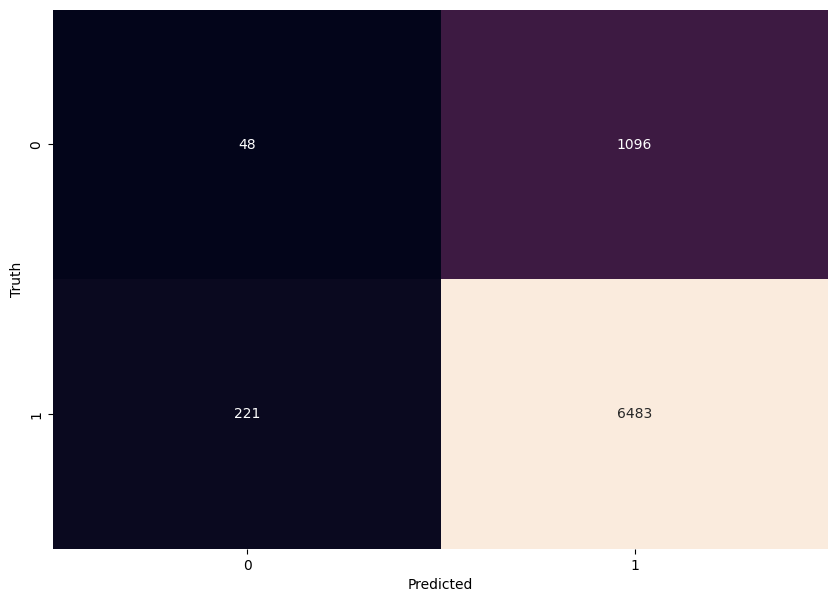

In [150]:
y_predicted  = knn.predict(x_test)
cm = confusion_matrix(y_test , y_predicted)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot = True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### 2. Confusion Matrix for Random Forest predictions

Text(95.72222222222221, 0.5, 'Truth')

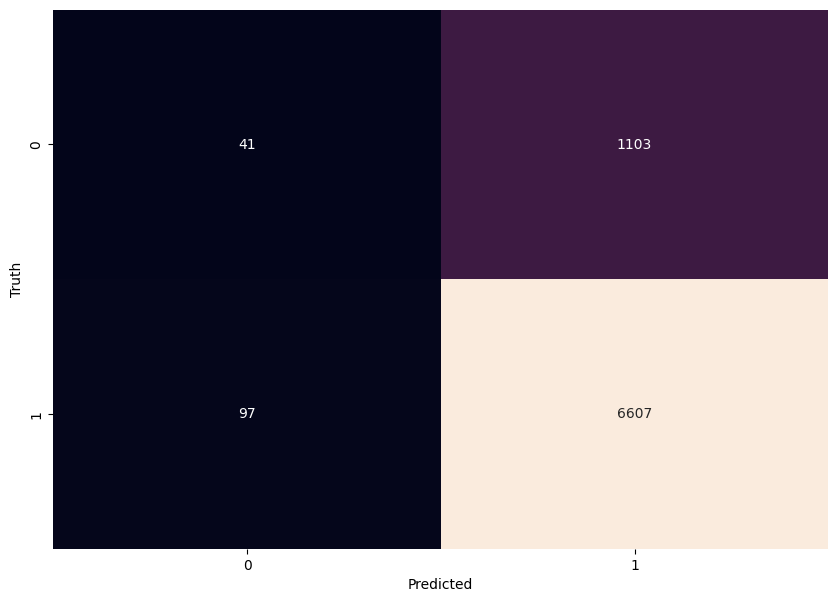

In [151]:
y_predicted  = rf.predict(x_test)
cm = confusion_matrix(y_test , y_predicted)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### 3. Confusion Matrix for SVM predictions

Text(95.72222222222221, 0.5, 'Truth')

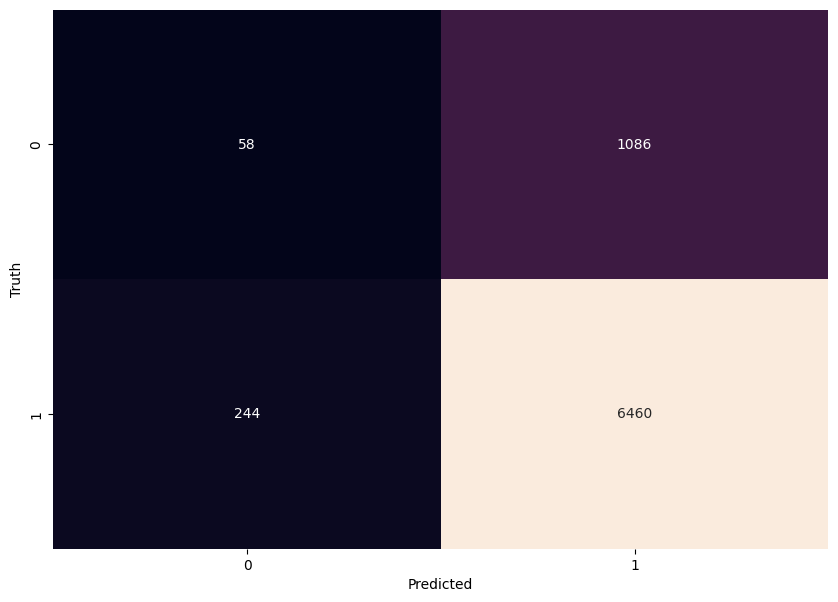

In [152]:
y_predicted  = clf.predict(x_test)
cm = confusion_matrix(y_test , y_predicted)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### 4. Confusion Matrix for Decision Tree predictions

Text(95.72222222222221, 0.5, 'Truth')

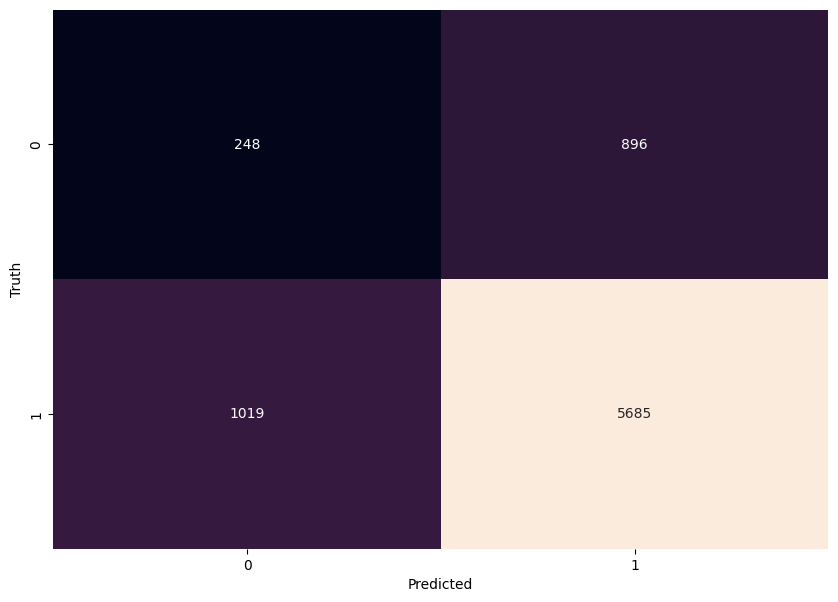

In [153]:
y_predicted  = dt.predict(x_test)
cm = confusion_matrix(y_test , y_predicted)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### 5. Confusion Matrix for XGBoost predictions

Text(95.72222222222221, 0.5, 'Truth')

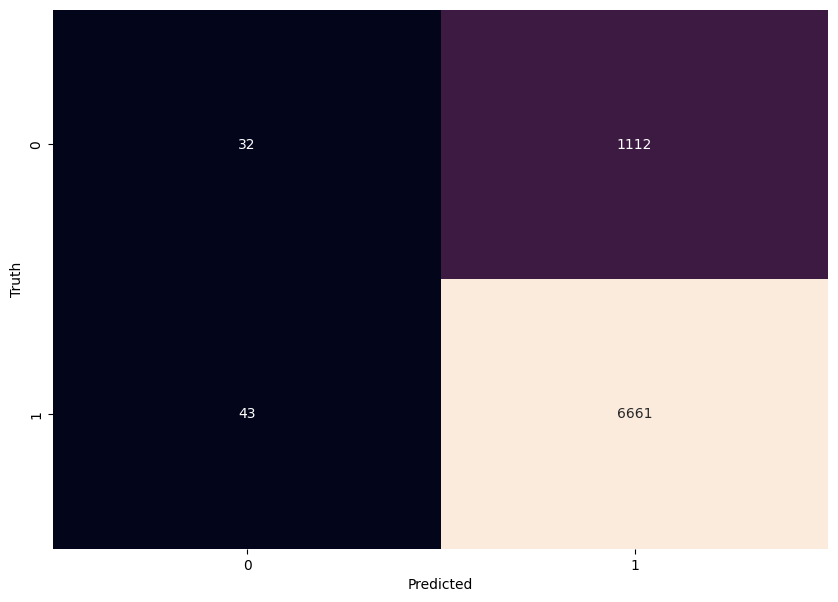

In [154]:
y_predicted  = xgbmodel.predict(x_test)
cm = confusion_matrix(y_test , y_predicted)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### 6. Confusion Matrix for Neural Network predictions

In [155]:
y_predicted = nn_model.predict(x_test)
y_predicted = y_predicted.argmax(axis=-1)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predicted)

246/246 [==============================] - 0s 1ms/step


0.145769622833843

Text(95.72222222222221, 0.5, 'Truth')

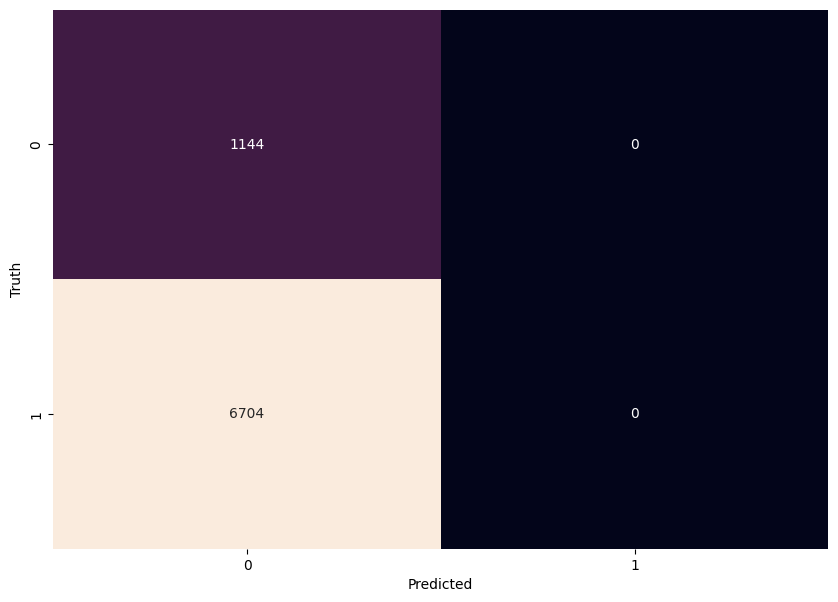

In [156]:
cm = confusion_matrix(y_test , y_predicted)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')